# Theory:
 * What methods do you know for generating independent samples of the standard normal distribution?
 * What variance reduction techniques do you know?
 * You just bought one share of stock A and want to hedge it by shorting stock B. How many shares of B should you short to minimize the variance of the hedged position?
 * How many comparisons do you need to find the maximum in a set of n distinct numbers? How many comparisons do you need to find both the max and min in a set of n distinct numbers?
 
This kind of task are strange for me. I can google and than implement any algorithm it's only depend on time only, so... there are my answers. Also i have to warn you that, all this things is only math and statistics for me so my vocabluary in this area is poor, but it is much more simpler than differencial equations and CV. So i'm studing quite fast.
 
 1.1 By using central limit theorem if you add N independent standard uniformly distributed random variables, then the distribution of the sum will be approximately normal. With N -> inf it will more like normal.
 
 1.2 Ziggurat algorithm https://en.wikipedia.org/wiki/Ziggurat_algorithm or Box-Muller Transformation https://mathworld.wolfram.com/Box-MullerTransformation.html

 2.1 Monte-Carlo or CRN from wikipedia and than google from extra info https://artowen.su.domains/mc/Ch-var-basic.pdf

 3.1 i will use something like Minimum Variance Hedge Ratio https://resources.wolframcloud.com/FormulaRepository/resources/Minimum-Variance-Hedge-Ratio#:~:text=The%20minimum%20variance%20hedge%20ratio%20equals%20the%20product%20of%20the,standard%20deviation%20futures%20price%20change. 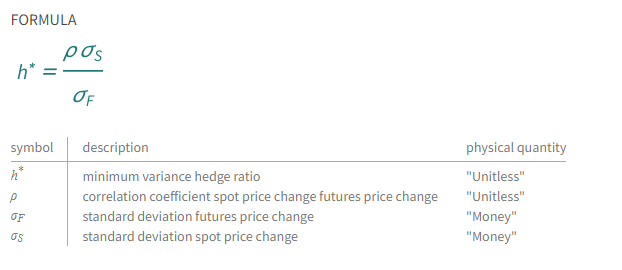
 
 4. n-1 for max only and 2n-2 for min max

Programming tasks (* without using PyPortflioOPT and any similar libraries, recurred programming language is Python/ Jupyter):
 1. Write the Mean Variance Optimization function/class for portfolio of n assets that will produce results of the following optimizations:
 * Minimum volatility
 * Maximum Sharpe Ratio
 * Efficient risk (minimize risk given a target return)
 * Efficient return
 * Maximum Diversification (for ref. Choueifaty, Yves, and Yves Coignard. 2008. “Toward Maximum Diversification.”)

Solution decription: 

I'm not sure how this task had to be done. Maybe all optimizations had to be in one algorithm, but i made class tha solve all problems separately and solve some extra problems. I did not make a good class structure because i got carried away by programming. It could be like main_class with some basic methods like mean_cov_calc, return computing and than some classes inheritated from that for doing optimizations.

1. First of all we have to get some data. In my solution method "download_info" read data with yfinance. Data period from .. to .. - daily, also we need tickers list of downloading assets and index_name for calc beta. After getting the data it has to be prepared (fix mislabeled, empties and so on) but this data is already prepared.
2. Stock_re_computing just calculate rate of returs (see formula 1) it returns self.returns
3. mean_cov_calc calcualte mean and covariance of stock return. 
4. calc_beta is calculating  financial elasticity as follows (see formula 2) it's requiered for understanding volatility of assets in compating with index (defult - S&P500). 
5. max_returns finds weights of portfolio with best return rate it is required for my mean variance optimization realization №1 
6. min_risk finds weights of portfolio with min risk it is required for my mean variance optimization realization №1
7. min_risk_max_ret my first realization of Mean-Variance Optimization. It computes combinations of risk/return and make a figure fo them. (see formula 3)
8. sharp_ratio_max Calculating maximal Sharpe Ratio for k-portfolio (see formula 4)
9. max_divirsification  - Calculating max divirsification Ratio for k-portfolio (see formula 5)
10. bi_criterion - mean variance optimization realization №2 with volatility (see formula 6) 
11. clastering - extra Funcion for making manual diversification  by clasterting
12. Summary - result of all optimizations

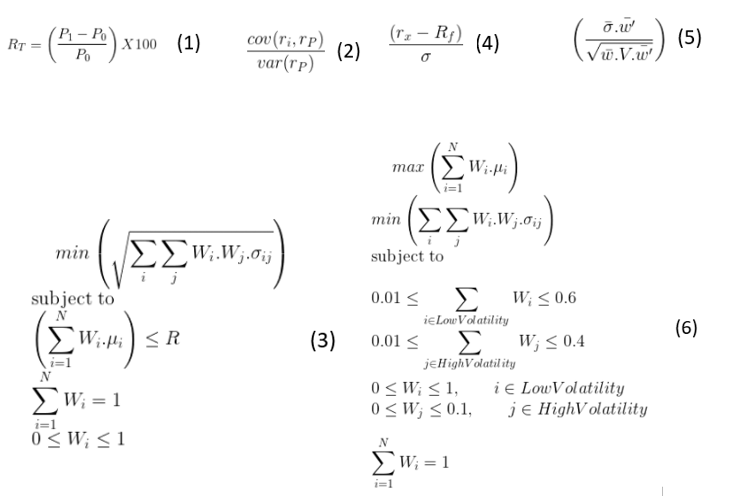

In [3]:
import pandas as pd
import yfinance as yf
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from scipy import optimize 
from sklearn.cluster import KMeans 

In [19]:
class Portfolio_Analysis():
    """init, tickers - our assets, start-end - period for analysis"""
    def __init__(self, tickers, start, end, index_name = '^GSPC') :
        self.tickers_list = tickers
        self.start_date = start
        self.end_date = end
        self.index_name = index_name

        
    """Load info with yfinance, structure of stock_price[asset][day]"""    
    def download_info(self):
        df = yf.download(self.tickers_list, start=self.start_date, end=self.end_date, group_by='tickers')
        sp500 = yf.download(self.index_name, start=self.start_date, end=self.end_date)
        self.index = sp500['Close'].to_numpy()
        # take only close
        df = df[df.columns[3::6]]
        # del multiindex
        df.columns = df.columns.droplevel(level=1)
        #extract asset labels - order of download assets
        self.asset_Labels = df.columns[0:].to_numpy()
        #extract asset prices data
        stock_price = np.array([])
        for i in range(len(self.asset_Labels)):
            temp = np.array(df.iloc[:, i])
            stock_price = np.append(stock_price, values=temp, axis=0)
        self.stock_price = stock_price.reshape(len(self.asset_Labels),-1)
        self.days = self.stock_price.shape[1]
        self.size = self.stock_price.shape[0]
        return self.stock_price

    
    # в базовый класс
    """Calculating partfolio returns"""  
    def stock_re_computing(self):
        returns = np.zeros([self.size, self.days])
        for i in range(self.size):  # i: Assets
            for j in range(self.days-1):     # j: Daily Prices
                returns[i,j]=((self.stock_price[i, j+1]-self.stock_price[i,j])/self.stock_price[i,j])*100
        self.returns = returns
        return self.returns
    
    
    """Calculating mean and cov of stock_price"""
    def mean_cov_calc(self):
        self.stock_re_computing()
        self.mean_returns = np.mean(self.returns, axis = 1)
        self.cov_returns = np.cov(self.returns, rowvar=True)
        return self.mean_returns, self.cov_returns
    
    
    """Calculationg of beta"""
    def calc_betas(self):
        self.mean_cov_calc()
        beta_returns = np.zeros([self.days])
        for j in range(self.days-1):     # j: Daily Prices
            beta_returns[j] = ((self.index[j+1] - self.index[j])/self.index[j])*100
        self.beta_returns = beta_returns
        beta = np.array([])
        
        for i in range(self.size):
            covar_mat = np.cov(self.beta_returns[:], self.returns[i, :])
            covar  = covar_mat[1, 0]
            beta = np.append(beta, covar / np.var(self.beta_returns, ddof =1))
            
        self.betas = beta
        return self.betas
    
    
    """function obtains maximal return portfolio
    it could be just max(self.mean_returns) :)"""
    def max_returns(self):
        self.mean_cov_calc()
        c = (np.multiply(-1, self.mean_returns))
        A = np.ones([self.size, 1]).T
        b = [1]
        res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex')
        self.max_returns_w = res.x
        self.max_exp_port_return = np.matmul(self.mean_returns.T, self.max_returns_w)

  
    """function obtains minimal risk portfolio"""
    def min_risk(self):
        self.mean_cov_calc()
        # define minimization of risk
        def  f(weights, cov_returns):
            return weights @ cov_returns @ weights.T 
        # define equality constraint representing fully invested portfolio
        def constraint_eq_w(weights):
            return  np.sum(weights) - 1
        
        xinit = np.repeat(0.1, self.size)
        cons = ({'type': 'eq', 'fun':constraint_eq_w})
        lb = 0
        ub = 1
        bnds = tuple([(lb,ub) for x in xinit])
        opt = optimize.minimize(fun = f,
                                x0 = xinit,
                                args = (self.cov_returns), 
                                bounds = bnds,
                                constraints = cons, 
                                tol = 10**-3).x
        
        self.min_risk_exp_port_return = self.mean_returns.T @ opt
        self.min_risk_w = opt

        
    #function obtains Minimal risk and Maximum return portfolios
    def __min_risk_max_ret_constr__(self, R, cov_returns, mean_returns):
        # define minimization of risk
        def  f(weights, cov_returns):
            func = weights @ cov_returns @ weights.T
            return func
        # define equality constraint representing fully invested portfolio
        def constraint_eq_w(weights):
            return np.sum(weights) - 1
        # define equality constraint representing max_return part
        def constraint_in_eq(weights, mean_returns, R):
            return mean_returns @ weights.T - R
            
        # making everything for optimize.minimize
        xinit = np.repeat(0.1, self.size)
        cons = ({'type': 'eq', 'fun':constraint_eq_w},
                {'type':'ineq', 'fun':constraint_in_eq,
                 'args':(mean_returns, R) })
        lb = 0
        ub = 1
        bnds = tuple([(lb,ub) for x in xinit])
        # hess = lambda x: np.zeros((n, n))   hess=hess, FIX ?
        opt = optimize.minimize(fun = f,
                                args = (cov_returns),
                                method ='trust-constr',
                                x0 = xinit,
                                bounds = bnds,
                                constraints = cons,
                                tol = 10**-3)
        return  opt     
    
    
    """Calculating efficient set for the maximum return and minimum risk portfolios"""
    def min_risk_max_ret(self):
        self.min_risk()
        self.max_returns()
        
        # start end points and step
        increment = 0.001
        low = self.min_risk_exp_port_return
        high = self.max_exp_port_return

        # initialize optimal weight set and risk-return point set
        x_optimal = np.array([])
        exp_port_return_point = np.array([])

        # repeated execution of function MinimizeRiskConstr to determine the efficient set 
        while (low < high):
            result = self.__min_risk_max_ret_constr__(low, self.cov_returns, self.mean_returns)
            x_optimal = np.append(x_optimal, result.x)
            exp_port_return_point = np.append(exp_port_return_point, low)
            low = low + increment
        # gather optimal weight set    
        self.min_risk_max_ret_w = x_optimal.reshape(-1, self.size)
        # obtain annualized risk for the efficient set portfolios 
        # @ = matmul
        min_risk_point = np.diagonal(self.min_risk_max_ret_w @ self.cov_returns @ np.transpose(self.min_risk_max_ret_w ))
        self.risk_point =   np.sqrt(min_risk_point * self.days) 
        # obtain expected portfolio annualized return for the 
        self.ret_point = self.days * exp_port_return_point
        # display efficient set portfolio parameters
        self.efficient_frontier(self.risk_point, self.ret_point)
#       return self.min_risk_max_ret_w, self.risk_point, self.ret_point, self.asset_Labels
        
        
    def __max_sharp_ratio_optimizer__(self, risk_free_rate, mean_returns, cov_returns):
        # define maximization of Sharpe Ratio
        def  f(weights, mean_returns, cov_returns, risk_free_rate):
            return -((mean_returns @ weights.T - risk_free_rate) / np.sqrt(weights @ cov_returns @ weights.T))
        # define equality constraint representing fully invested portfolio
        def constraintEq(weights):
            return np.sum(weights) - 1

        # define bounds and other parameters
        xinit = np.repeat(0.2, self.size)
        cons = ({'type': 'eq', 'fun':constraintEq})
        lb = 0
        ub = 1
        bnds = tuple([(lb,ub) for x in xinit])

        #invoke minimize solver
        opt = optimize.minimize (fun = f,
                                 x0 = xinit,
                                 args = (mean_returns, cov_returns, risk_free_rate),
                                 method = 'SLSQP',
                                 bounds = bnds,
                                 constraints = cons,
                                 tol = 10**-3)

        return opt
        
        
    """Calculating maximal Sharpe Ratio for k-portfolio"""
    def sharp_ratio_max(self, rf = 4, display = True):
        self.mean_cov_calc()
        # set risk free asset rate of return
        ann_risk_free = rf/100

        # compute daily risk free rate in percentage
        r0 = (np.power((1 + ann_risk_free),  (1.0 / 365.0)) - 1.0) * 100 

        # initialization
        x_optimal = np.array([])
        min_risk_point_sharpe = np.array([])
        exp_port_return_point_sharpe = np.array([])

        # compute maximal Sharpe Ratio and optimal weights
        result = self.__max_sharp_ratio_optimizer__(r0, self.mean_returns, self.cov_returns)
        x_optimal = np.append(x_optimal, result.x)
        x_optimal = x_optimal.reshape(-1, self.size)

        # compute risk returns and max Sharpe Ratio of the optimal portfolio   
        risk = x_optimal @ self.cov_returns @ np.transpose(x_optimal)
        exp_return = self.mean_returns @ x_optimal.T
        ann_risk =   np.sqrt(risk*self.days) 
        ann_ret = self.days*np.array(exp_return) 
        self.max_sharpe_ratio = (ann_ret - rf)/ann_risk 

        # set precision for printing results
        np.set_printoptions(precision=3, suppress = True)

        if display:# display results
            print('Maximal Sharpe Ratio: ', self.max_sharpe_ratio, '\nAnnualized Risk (%):  ', \
                  ann_risk, '\nAnnualized Expected Portfolio Return(%):  ', ann_ret)
            print('\nOptimal weights (%):\n',  x_optimal*100 )

    
    """Calculating max divirsification Ratio for k-portfolio"""
    def max_divirsification(self):
        self.mean_cov_calc()
        # define function to optimize
        def calc_diversification_ratio(weights, cov_returns):
            # average weighted vol
            w_vol = np.dot(np.sqrt(np.diag(cov_returns)), weights.T)
            # portfolio vol
            port_vol = np.sqrt(np.dot(np.dot(weights, cov_returns), weights.T))
            diversification_ratio = w_vol/port_vol
            # return negative for minimization problem (maximize = minimize -)
            return -diversification_ratio
        # define equality constraint representing fully invested portfolio
        def constraintEq(weights):
            return np.sum(weights) - 1 
        
        # all stuff for minimize
        xinit = np.repeat(0.1, self.size)
        lb = 0
        ub = 1
        bnds = tuple([(lb,ub) for x in xinit])
        cons = ({'type': 'eq', 'fun': constraintEq},)
        res = optimize.minimize(fun = calc_diversification_ratio,
                                x0 = xinit,
                                bounds = bnds,
                                args=self.cov_returns,
                                method='SLSQP',
                                constraints = cons)
        self.max_diversification_w = res.x
        self.max_deversification_ratio = -res.fun
#         return self.max_divirsification_w
    
            
    def __bi_criterion_optimizator__(self,
                                     mean_returns,
                                     cov_returns,
                                     risk_avers,
                                     size,
                                     bnds,
                                     up_sum_bound,
                                     low_sum_bound):
        # define function to optimize
        def f(weights, mean_returns, cov_returns, risk_avers):
            return risk_avers * (weights @ cov_returns @ weights.T) - (1 - risk_avers) * (mean_returns @ weights.T)
        # define equality constraint representing fully invested portfolio
        def constraint_w(weights):
            return np.sum(weights) - 1
        # define one bouns on W
        def constraint_up_w_bounds(weights):
            return np.array(up_sum_bound).T - self.volatility @ weights.T
        # define the other bounds on W
        def constraint_low_w_bounds(weights): 
            return  self.volatility @ weights.T - np.array(low_sum_bound).T 

        xinit = np.repeat(0.01, size)
        # how to change bounds
        cons = ({'type': 'eq', 'fun':constraint_w}, \
                {'type':'ineq', 'fun': constraint_up_w_bounds},\
                {'type':'ineq', 'fun': constraint_low_w_bounds})


        opt = optimize.minimize (fun = f,
                                     x0 = xinit,
                                     args = (mean_returns, cov_returns, risk_avers),
                                     method = 'SLSQP',
                                     bounds = bnds,
                                     constraints = cons,
                                     tol = 10**-3)
        return opt
    
    
    """Function to handle bi-criterion portfolio optimization with constraints
    obtain optimal portfolios for the constrained portfolio optimization model
    Maximize returns and Minimize risk with fully invested, bound and class constraints"""
    def bi_criterion(self,
                     n_point,
                     low_vol_up_sum_bound  = 0.4,
                     high_vol_up_sum_bound = 0.6,
                     low_vol_low_sum_bound  = 0.1,
                     high_vol_low_sum_bound = 0.1,
                     display = True):
        
        self.mean_cov_calc()
        self.calc_betas()

        
        volatility = np.array([])
        not_volatility = np.array([])
        for beta in self.betas:
            if beta >= 1:
                volatility = np.append(volatility, 1)
                not_volatility = np.append(not_volatility, 0)
            else:
                volatility = np.append(volatility, 0)
                not_volatility = np.append(not_volatility, 1)
                
        volatility = np.append(volatility, not_volatility)
        self.volatility = volatility.reshape(-1, self.size)
        bnds = []
        for beta in self.betas:
            if beta >= 1:
                bnds.append((0, 1))
            else:
                bnds.append((0, 0.1))     
        
        x_optimal = np.array([])

        for points in range(0, n_point):
            risk_avers = points/n_point
            result = self.__bi_criterion_optimizator__(self.mean_returns,
                                                       self.cov_returns,
                                                       risk_avers,
                                                       self.size,
                                                       bnds,
                                                       up_sum_bound = [low_vol_up_sum_bound,high_vol_up_sum_bound],
                                                       low_sum_bound = [low_vol_low_sum_bound,high_vol_low_sum_bound])
            x_optimal = np.append(x_optimal, result.x)

        # gather optimal weight set    
        self.opt_risk_ret_vol_w = x_optimal.reshape(-1, self.size)

        # obtain annualized risk for the efficient set portfolios 
        min_risk_point = np.diagonal(self.opt_risk_ret_vol_w @ self.cov_returns @ np.transpose(self.opt_risk_ret_vol_w ))
        self.risk_point_vol =   np.sqrt(min_risk_point * self.days) 

        # obtain expected portfolio annualized return for the 
        exp_port_return_point= self.opt_risk_ret_vol_w @ self.mean_returns
        self.ret_point_vol = self.days * exp_port_return_point
        # display efficient set portfolio parameters
        if display:
            self.efficient_frontier(self.risk_point_vol, self.ret_point_vol)
    
    
    """Some drawing stuff"""
    def efficient_frontier(self, risk_point, ret_point):
        n_points = risk_point.size
        colours = "green"
        area = np.pi*3

        plt.title('Efficient Frontier for k-portfolio 1 of Dow stocks')
        plt.xlabel('Annualized Risk(%)')
        plt.ylabel('Annualized Expected Portfolio Return(%)' )
        plt.scatter(risk_point, ret_point, s=area, c=colours, alpha = 0.5)
        plt.show()
        
        
    """Extra Funcion for making manual diversification  by clasterting"""
    def clastering(self, clusters, max_iterations = 1000):
        self.mean_cov_calc()
        # prepare asset parameters for k-means clustering
        # reshape for concatenation
        mean_returns_temp = self.mean_returns.reshape(len(self.mean_returns), 1)
        asset_param = np.concatenate([mean_returns_temp, self.cov_returns], axis = 1)
        # k means clustering of assets using the characteristic vector of 
        # mean return and variance-covariance vector of returns
        assets_clusters = KMeans(algorithm='auto',  max_iter=max_iterations, n_clusters=clusters)
        assets_clusters.fit(asset_param)
        centroids = assets_clusters.cluster_centers_
        labels = assets_clusters.labels_
        
        # asset labels to cluster points
        print('Stocks in each of the clusters:',)
        for i in range(clusters):
            print('Cluster', i+1)
            clt  = np.where(labels == i)
            assets_cluster = self.asset_Labels[clt]
            print(assets_cluster)
            
    
    """Provides all portfolio info"""
    def summary(self):
        self.calc_betas()
        print('Summary info for your: ', k.asset_Labels)
        print('Beta for index named: ', self.index_name)
        print(self.betas)
        self.max_returns()
        print()
        print("Maximal Expected Portfolio Return:   %7.4f" % self.max_exp_port_return)
        print('Weights of that portfolio (%):', self.max_returns_w*100)
        self.min_risk()
        print("Expected Return of Minimum Risk Portfolio:  %7.4f" % self.min_risk_exp_port_return)
        print('Weights of that portfolio (%):', self.min_risk_w*100)
        print('\nEfficient Frontier for k-portfolio method 1')
        self.min_risk_max_ret()
        self.sharp_ratio_max(display=False)
        self.max_divirsification()
        print('Max divirsification portfolio: ')
        print('Max diversification ratio:', self.max_deversification_ratio)
        print('Weights of that portfolio (%):', self.max_diversification_w*100)
        print('\nInfo for manual deversification by n/5 clasters: ')
        self.clastering(round(self.size/5))
        print('\nEfficient Frontier for k-portfolio method 2 with following conditions:')
        print('1. Max return min risk')
        print('2. 30% of the capital is invested in high volatility stocks, 70% invested in low volatility stocks.')
        print('3. Weights of low volatility stocks can have an upper bound of 1 ( 𝑊𝑖≤1 ), those of high volatility stocks cannot exceed 0.1 ( 𝑊𝑖≤0.1 )')
        print('4. Fully invested portfolio')
        self.bi_criterion(n_point = 100,
                          low_vol_up_sum_bound  = 0.3,
                          high_vol_up_sum_bound = 0.7,
                          low_vol_low_sum_bound  = 0.01,
                          high_vol_low_sum_bound = 0.01,)

In [20]:
tickers_list = ['AAPL', 'MSFT', 'GOOG', 'TSLA', 'CSCO', 'DIS', 'JNJ', 'ADI', 'IBM', 'AEP', 'KO', 'MCD', 'MRK', 'CL', 'WBA']
k = Portfolio_Analysis(tickers_list, "2017-11-02", "2022-11-02")
price = k.download_info()

[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  1 of 1 completed


Summary info for your:  ['ADI' 'TSLA' 'CSCO' 'GOOG' 'MCD' 'MRK' 'KO' 'AAPL' 'DIS' 'CL' 'JNJ' 'IBM'
 'MSFT' 'WBA' 'AEP']
Beta for index named:  ^GSPC
[1.258 1.37  1.034 1.09  0.788 0.62  0.664 1.203 0.984 0.569 0.624 0.915
 1.199 0.813 0.516]

Maximal Expected Portfolio Return:    0.3383
Weights of that portfolio (%): [  0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]
Expected Return of Minimum Risk Portfolio:   0.0405
Weights of that portfolio (%): [ 0.     0.918  0.     5.408 12.351 14.801  8.222  0.     2.462 17.265
 18.3    0.     0.     2.594 17.68 ]

Efficient Frontier for k-portfolio method 1


C:\Users\Stanislav\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


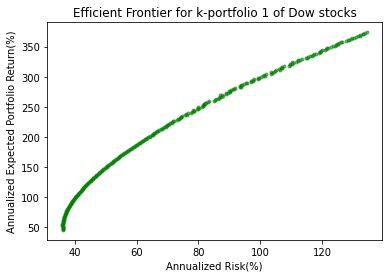

Max divirsification portfolio: 
Max diversification ratio: 1.608907599093589
Weights of that portfolio (%): [ 4.412 12.543  0.     2.921  2.841 16.003  0.     0.    10.408  9.053
  3.218  0.283  0.    14.078 24.239]

Info for manual deversification by n/5 clasters: 
Stocks in each of the clusters:
Cluster 1
['ADI' 'CSCO' 'GOOG' 'AAPL' 'DIS' 'MSFT']
Cluster 2
['TSLA']
Cluster 3
['MCD' 'MRK' 'KO' 'CL' 'JNJ' 'IBM' 'WBA' 'AEP']

Efficient Frontier for k-portfolio method 2 with following conditions:
1. Max return min risk
2. 30% of the capital is invested in high volatility stocks, 70% invested in low volatility stocks.
3. Weights of low volatility stocks can have an upper bound of 1 ( 𝑊𝑖≤1 ), those of high volatility stocks cannot exceed 0.1 ( 𝑊𝑖≤0.1 )
4. Fully invested portfolio


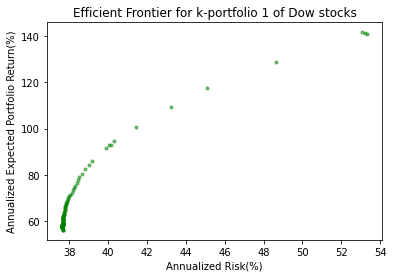

In [21]:
k.summary()

In [97]:
k.calc_betas(), k.asset_Labels

(array([1.034, 1.212, 1.162, 0.813, 1.323, 0.62 , 0.788, 1.203, 0.984,
        0.665, 1.539, 1.05 , 0.915, 1.006, 1.014]),
 array(['CSCO', 'GS', 'JPM', 'WBA', 'AXP', 'MRK', 'MCD', 'AAPL', 'DIS',
        'KO', 'BA', 'CAT', 'IBM', 'UNH', 'HD'], dtype=object))

In [98]:
k.max_returns()
k.max_returns_w , k.asset_Labels

(array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array(['CSCO', 'GS', 'JPM', 'WBA', 'AXP', 'MRK', 'MCD', 'AAPL', 'DIS',
        'KO', 'BA', 'CAT', 'IBM', 'UNH', 'HD'], dtype=object))

In [99]:
k.min_risk()
k.min_risk_w, k.asset_Labels

(array([0.005, 0.   , 0.   , 0.08 , 0.   , 0.286, 0.184, 0.033, 0.026,
        0.341, 0.   , 0.   , 0.02 , 0.   , 0.027]),
 array(['CSCO', 'GS', 'JPM', 'WBA', 'AXP', 'MRK', 'MCD', 'AAPL', 'DIS',
        'KO', 'BA', 'CAT', 'IBM', 'UNH', 'HD'], dtype=object))

C:\Users\Stanislav\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


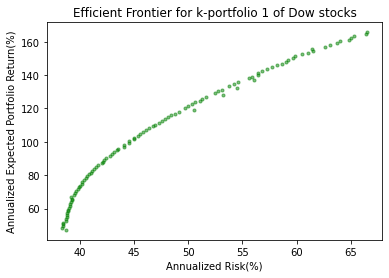

(array([0.024, 0.009, 0.009, 0.044, 0.005, 0.28 , 0.16 , 0.033, 0.027,
        0.301, 0.003, 0.018, 0.028, 0.023, 0.036]),
 array(['CSCO', 'GS', 'JPM', 'WBA', 'AXP', 'MRK', 'MCD', 'AAPL', 'DIS',
        'KO', 'BA', 'CAT', 'IBM', 'UNH', 'HD'], dtype=object))

In [100]:
k.min_risk_max_ret()
k.min_risk_max_ret_w[0], k.asset_Labels

In [101]:
k.sharp_ratio_max()

Maximal Sharpe Ratio:  [[2.416]] 
Annualized Risk (%):   [[54.143]] 
Annualized Expected Portfolio Return(%):   [134.833]

Optimal weights (%):
 [[ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 2.231]
 [ 9.101]
 [ 0.   ]
 [57.198]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [24.506]
 [ 6.964]]


In [102]:
k.clastering(5)

Stocks in each of the clusters:

Cluster 1
['MRK' 'MCD' 'KO']
Cluster 2
['GS' 'JPM' 'AXP']
Cluster 3
['BA']
Cluster 4
['WBA']
Cluster 5
['CSCO' 'AAPL' 'DIS' 'CAT' 'IBM' 'UNH' 'HD']


In [103]:
k.max_divirsification()
k.max_divirsification_w, k.max_deversification_ratio

(array([0.   , 0.   , 0.   , 0.173, 0.   , 0.235, 0.101, 0.119, 0.097,
        0.074, 0.071, 0.052, 0.005, 0.056, 0.017]),
 1.4518327613703483)

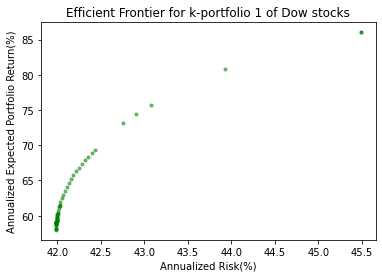

In [104]:
k.bi_criterion(n_point = 60)